In [1]:
#Set notebook figure print parameters
options(repr.plot.width=20, repr.plot.height=80, repr.plot.res = 400, repr.plot.quality = 500, repr.plot.pointsize = 12)

# Set working directory
setwd('/Users/leesh/Documents/MS analysis pipeline/Benezra_pilot oxidised lipids/Full set/')

#install.packages("ggplot2",repos='http://cran.us.r-project.org',dependencies = TRUE)
#install.packages("dplyr",repos='http://cran.us.r-project.org',dependencies = TRUE)
#install.packages("reshape",repos='http://cran.us.r-project.org',dependencies = TRUE)
#install.packages("data.table",repos='http://cran.us.r-project.org',dependencies = TRUE)
#install.packages("reshape2",repos='http://cran.us.r-project.org',dependencies = TRUE)
#install.packages("Polychrome",repos='http://cran.us.r-project.org',dependencies = TRUE)
#install.packages("here",repos='http://cran.us.r-project.org',dependencies = TRUE)




In [2]:
# Load packages

library ('ggplot2')
library ("data.table")
library("dplyr")
library("reshape")
library('reshape2')
library("Polychrome")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following object is masked from ‘package:data.table’:

    melt



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


The following objects are masked from ‘package:data.table’:

    dcast, melt




### Set color palette

In [3]:
options(repr.plot.width=50, repr.plot.height=10, repr.plot.res = 200, repr.plot.quality = 300, repr.plot.pointsize = 12)
# Create a color palette for the features
set.seed(723451) # for reproducibility
ConditionsPalette <- createPalette(50, c("#0ACFF6", "#f6310a"), M=1000)
#swatch (ConditionsPalette)
ConditionsPalette_list <- as.list(ConditionsPalette)
names(ConditionsPalette) <- NULL



## Import data and reshape into tidy format (rows are samples, columns are metabolite intensities)

In [4]:
# Import data from lipid annotator csv
All <- read.csv('/Users/leesh/Documents/MS analysis pipeline/Benezra_pilot oxidised lipids/Full set/csvs to combine for PCDL/All_samples_Pooled_NegativeMode.csv')
cells_4T1 <- read.csv('/Users/leesh/Documents/MS analysis pipeline/Benezra_pilot oxidised lipids/Full set/csvs to combine for PCDL/4T1_Pooled_NegativeMode.csv')
cells_HCT <- read.csv('/Users/leesh/Documents/MS analysis pipeline/Benezra_pilot oxidised lipids/Full set/csvs to combine for PCDL/HCT_Pooled_NegativeMode.csv')
cells_TK1 <- read.csv('/Users/leesh/Documents/MS analysis pipeline/Benezra_pilot oxidised lipids/Full set/csvs to combine for PCDL/TK1_Pooled_NegativeMode.csv')

In [5]:
#### Function to add column signifiying PCDL, a unique name (Compound name - RT - ion species) and  remove empty rows from csv of all features (just leave annotated features)
Add_PCDL_Column_RemoveEmpty <- function(df, name) {
df <- df %>% mutate (PCDL = name, UniqueName = paste(Compound.Name, RT, Ion.Species	, sep = '-'))
df <- df[!(df$Lipid.Class==""), ]
}

In [6]:
# Create dfs to be used for pie charts

All <-  Add_PCDL_Column_RemoveEmpty(All, "All") 
cells_4T1 <- Add_PCDL_Column_RemoveEmpty (cells_4T1, "cells_4T1")
cells_HCT <- Add_PCDL_Column_RemoveEmpty (cells_HCT, "cells_HCT")
cells_TK1 <- Add_PCDL_Column_RemoveEmpty (cells_TK1, "cells_TK1")

In [7]:
## create concatenated master PCDL (including duplicates)

combinedPCDL_allrows <- rbind(All, cells_4T1,cells_HCT,cells_TK1)

In [8]:
#### Function to summarise number of annotated features)
Summarise <- function(df,group_var) {
group_var <- enquo(group_var) 
  summary_df <- df %>%
    dplyr::group_by(!!group_var) %>%        
    summarise(n = n())
    return (summary_df)
    }

In [9]:
Summarise(combinedPCDL_allrows, PCDL)

PCDL,n
<chr>,<int>
All,449
cells_4T1,426
cells_HCT,504
cells_TK1,348


### Individual pie charts for each data table

### summarize data

In [10]:
####  Function to select relevant columns

ColumnSelect <- function(df) {
selectdf <- df %>%
    select (Feat.ID, Abundance, Lipid.Class, Score)
    return (selectdf)
    }

In [11]:
PooledQC_all_cells <- ColumnSelect(All) #enter dfs created above
PooledQC_4T1_cells <- ColumnSelect(cells_4T1)
PooledQC_HCT_cells  <- ColumnSelect(cells_HCT)
PooledQC_TK1_cells <- ColumnSelect(cells_TK1)

In [12]:
####  Function to select create data tables for pie charts

PieDataTable <- function(df) {
Summary <- df %>%
    group_by(Lipid.Class) %>%
    summarize(Counts = n())
#Add percent
    Counts_percent <- Summary %>%
            mutate(Lipid.Class = factor(Lipid.Class, 
            levels = Lipid.Class[length(Lipid.Class):1]),
            cumulative = cumsum(Counts),
            midpoint = cumulative - Counts / 2,
            labels = paste0(round((Counts/ sum(Counts)) * 100, 2), "%"))  
     dataframename <- deparse(substitute(df))
     Counts_percent <- Counts_percent %>% mutate (Cell_method = dataframename)
    return (Counts_percent)
    }



In [13]:
PieData_All <- PieDataTable (PooledQC_all_cells) #enter dfs created above (selected columns)
PieData_cells_4T1 <- PieDataTable (PooledQC_4T1_cells)
PieData_cells_HCT <- PieDataTable (PooledQC_HCT_cells)
PieData_cells_TK1 <- PieDataTable (PooledQC_TK1_cells)


In [14]:
# Bind all data together for stacked bar plot faceted by group
Counts_all <- rbind(PieData_All,PieData_cells_4T1, PieData_cells_HCT, PieData_cells_TK1)#enter dfs created above

### create df in format for base R pie chart


In [15]:
#long > wide for pie chart to keep palette consistent across charts
wide_Counts_all <- dcast(Counts_all, Cell_method ~  Lipid.Class, value.var="Counts")

#Replace NAs with zero (as blanks will have many missing values)
wide_Counts_all <- wide_Counts_all %>% 
mutate_if(is.numeric, ~replace(., is.na(.), 0))

#Transpose such that each row is a lipid species annotation
wide_Counts_all <- as.data.frame(t(wide_Counts_all))

#Make first row column names
colnames(wide_Counts_all) <- wide_Counts_all[1,]
wide_Counts_all <- wide_Counts_all[-1, ] 

#Change column class to numeric
wide_Counts_all <- wide_Counts_all %>% 
  mutate_all(~as.numeric(as.character(.))) 

#Make row name Lipid.Class column
wide_Counts_all <- setDT(wide_Counts_all, keep.rownames = "Lipid.Class")

In [16]:
####  Function to split into separate tables for each lipid annotator file (and pie chart) and add percent

Pie <- function(wide_Counts_all, select_df) {
Pie <- wide_Counts_all %>%
    select (Lipid.Class,all_of(select_df))
colnames(Pie) <- c("Lipid.Class", "Counts")
Pie$Counts <- as.numeric(Pie$Counts)
Pie <- Pie  %>%
    mutate(Lipid.Class = factor(Lipid.Class, 
    levels = Lipid.Class[length(Lipid.Class):1]),
    cumulative = cumsum(Counts),
    midpoint = cumulative - Counts / 2,
    labels = paste0(round((Counts/ sum(Counts)) * 100, 2), "%"))  
    return (Pie)
    }

In [17]:
names (wide_Counts_all)

[1] "Lipid.Class"        "PooledQC_4T1_cells" "PooledQC_HCT_cells"
[4] "PooledQC_TK1_cells" "PooledQC_all_cells"

In [18]:
Pie_All <- Pie (wide_Counts_all, "PooledQC_all_cells") # df, then column name from df for each lipid annotator file (see above)
Pie_4T1 <- Pie (wide_Counts_all, "PooledQC_4T1_cells")
Pie_HCT <- Pie (wide_Counts_all, "PooledQC_HCT_cells")
Pie_TK1 <- Pie (wide_Counts_all, "PooledQC_TK1_cells")

In [19]:
####  function to print piechart figures in notebook

Print_Pie <- function(df, na.rm = TRUE, ...) {
  dataframename <- deparse(substitute(df))
pie(df$Counts,
    labels = paste(df$Lipid.Class, sep = " ", Pie_All$labels), 
    col = ConditionsPalette,
    border="white",
    main = dataframename,
    radius = 0.7, cex = 0.8)
       }

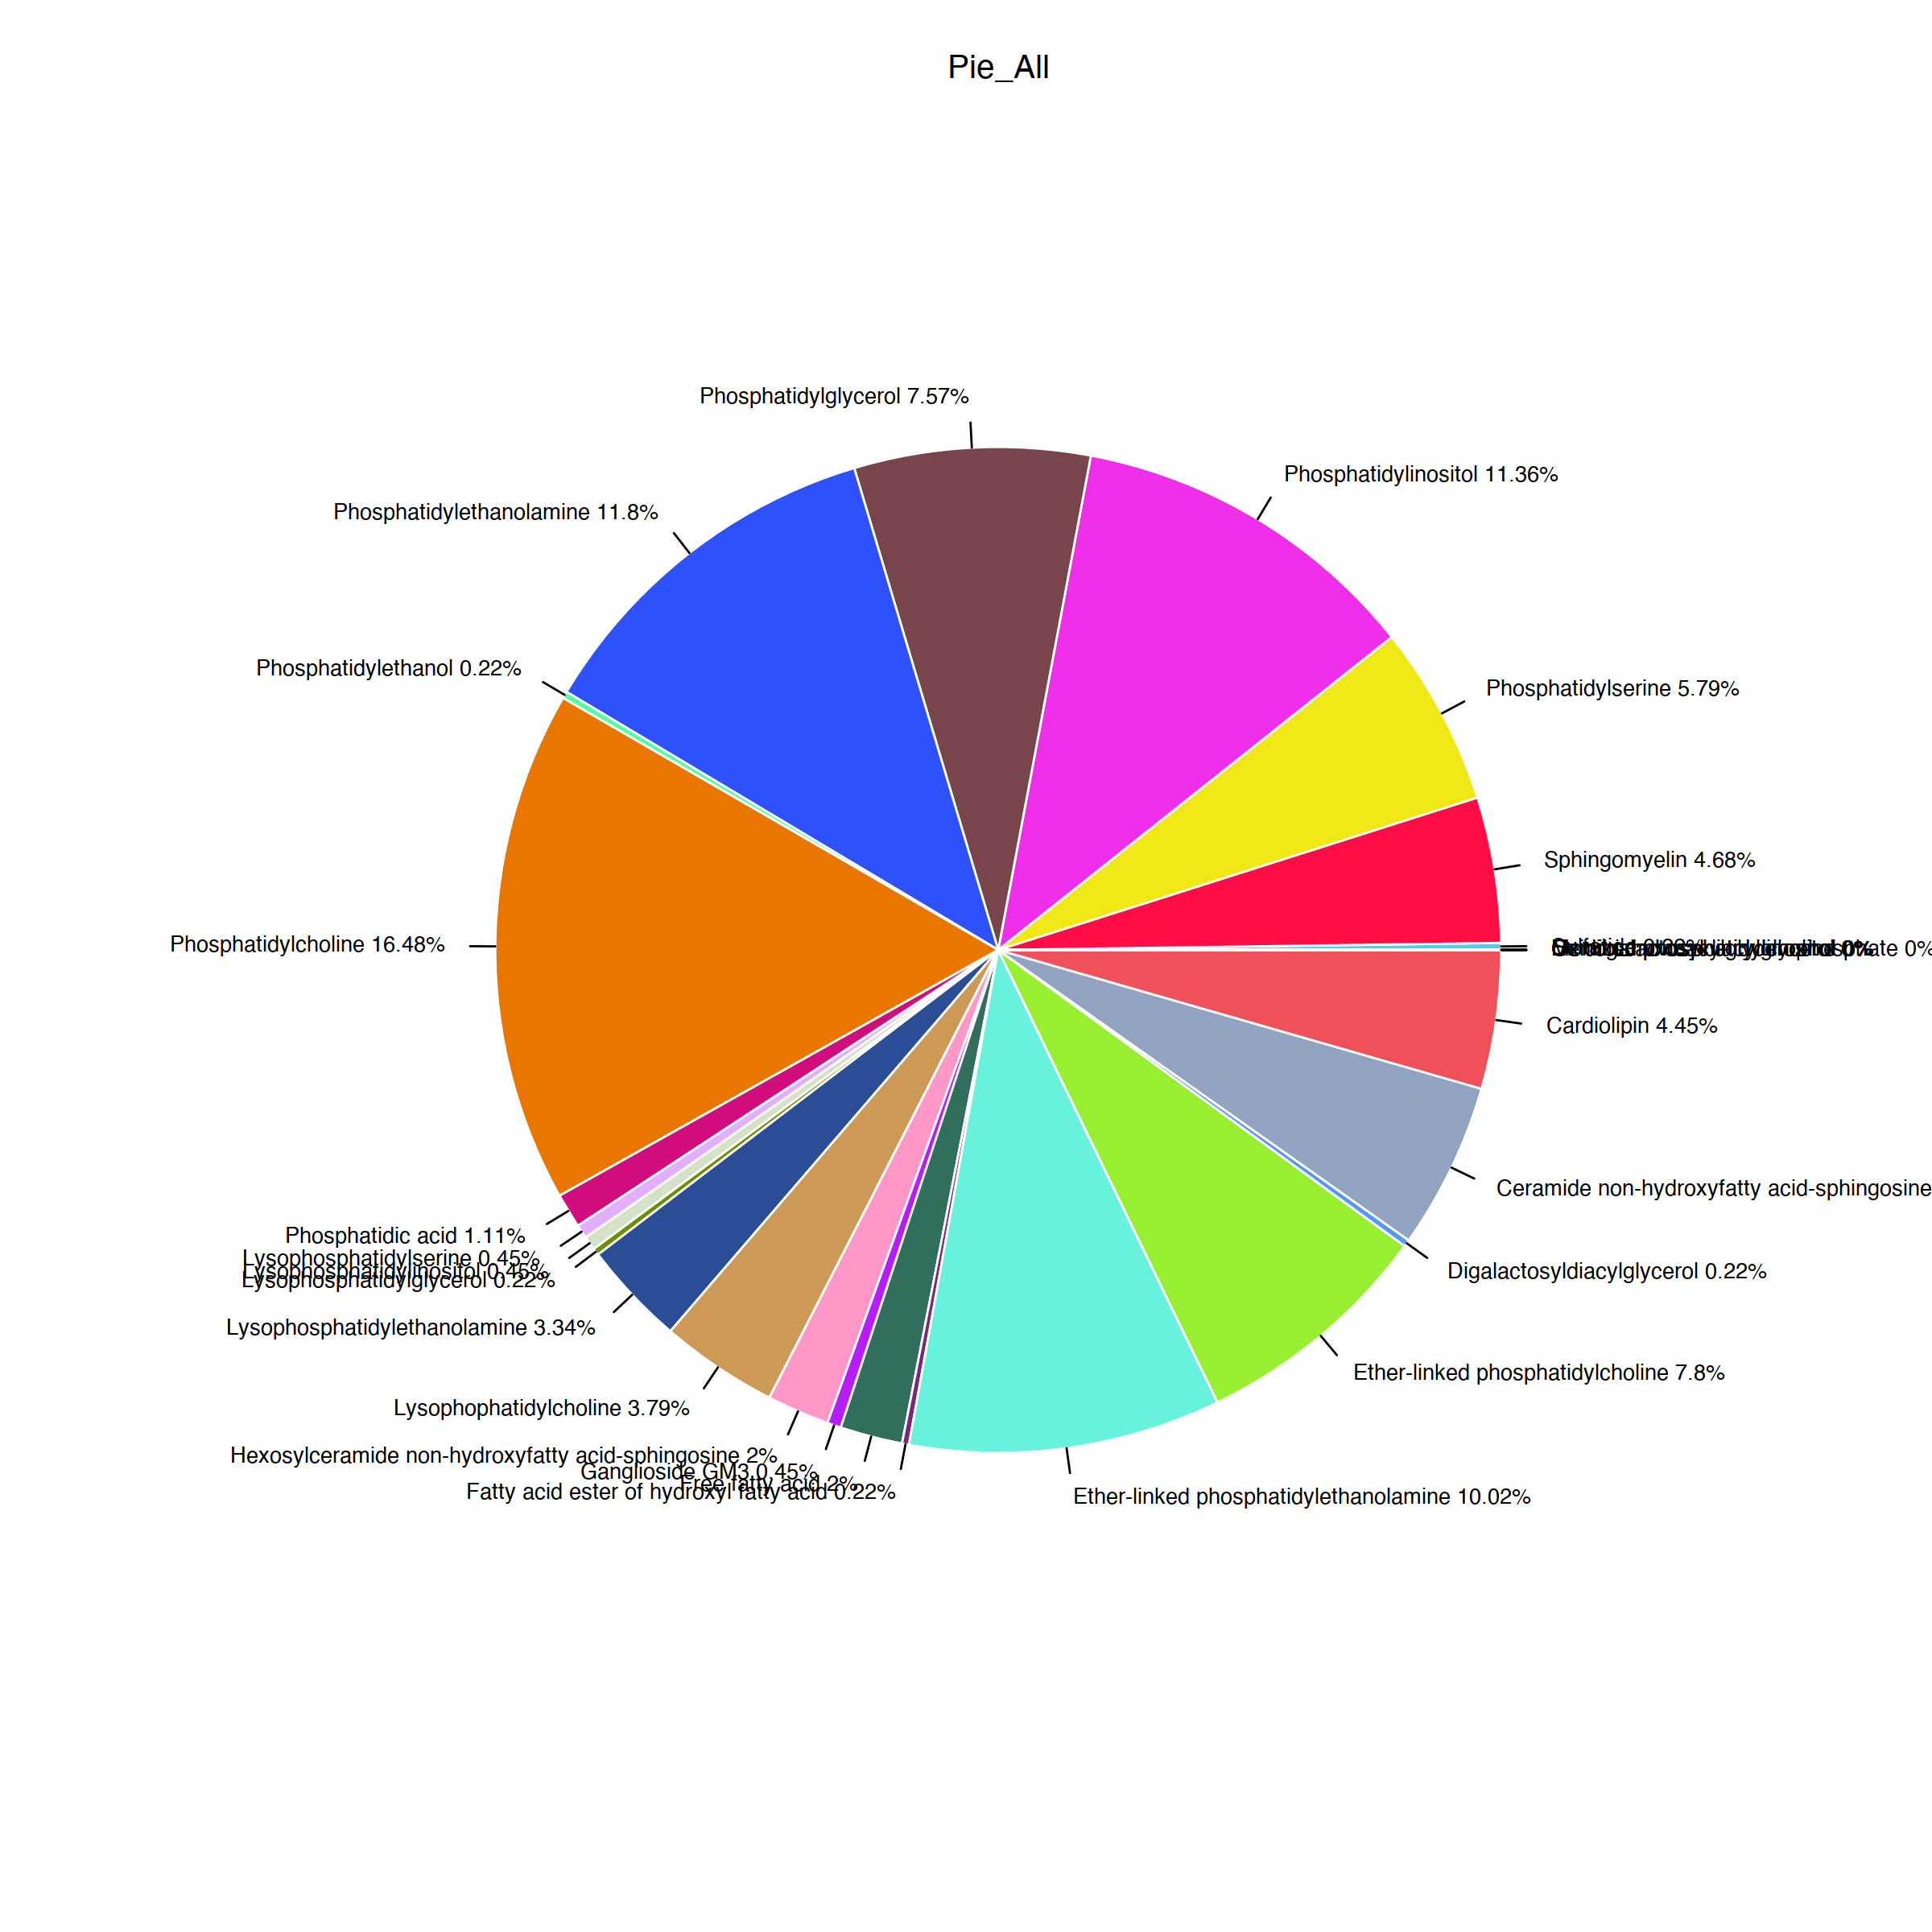

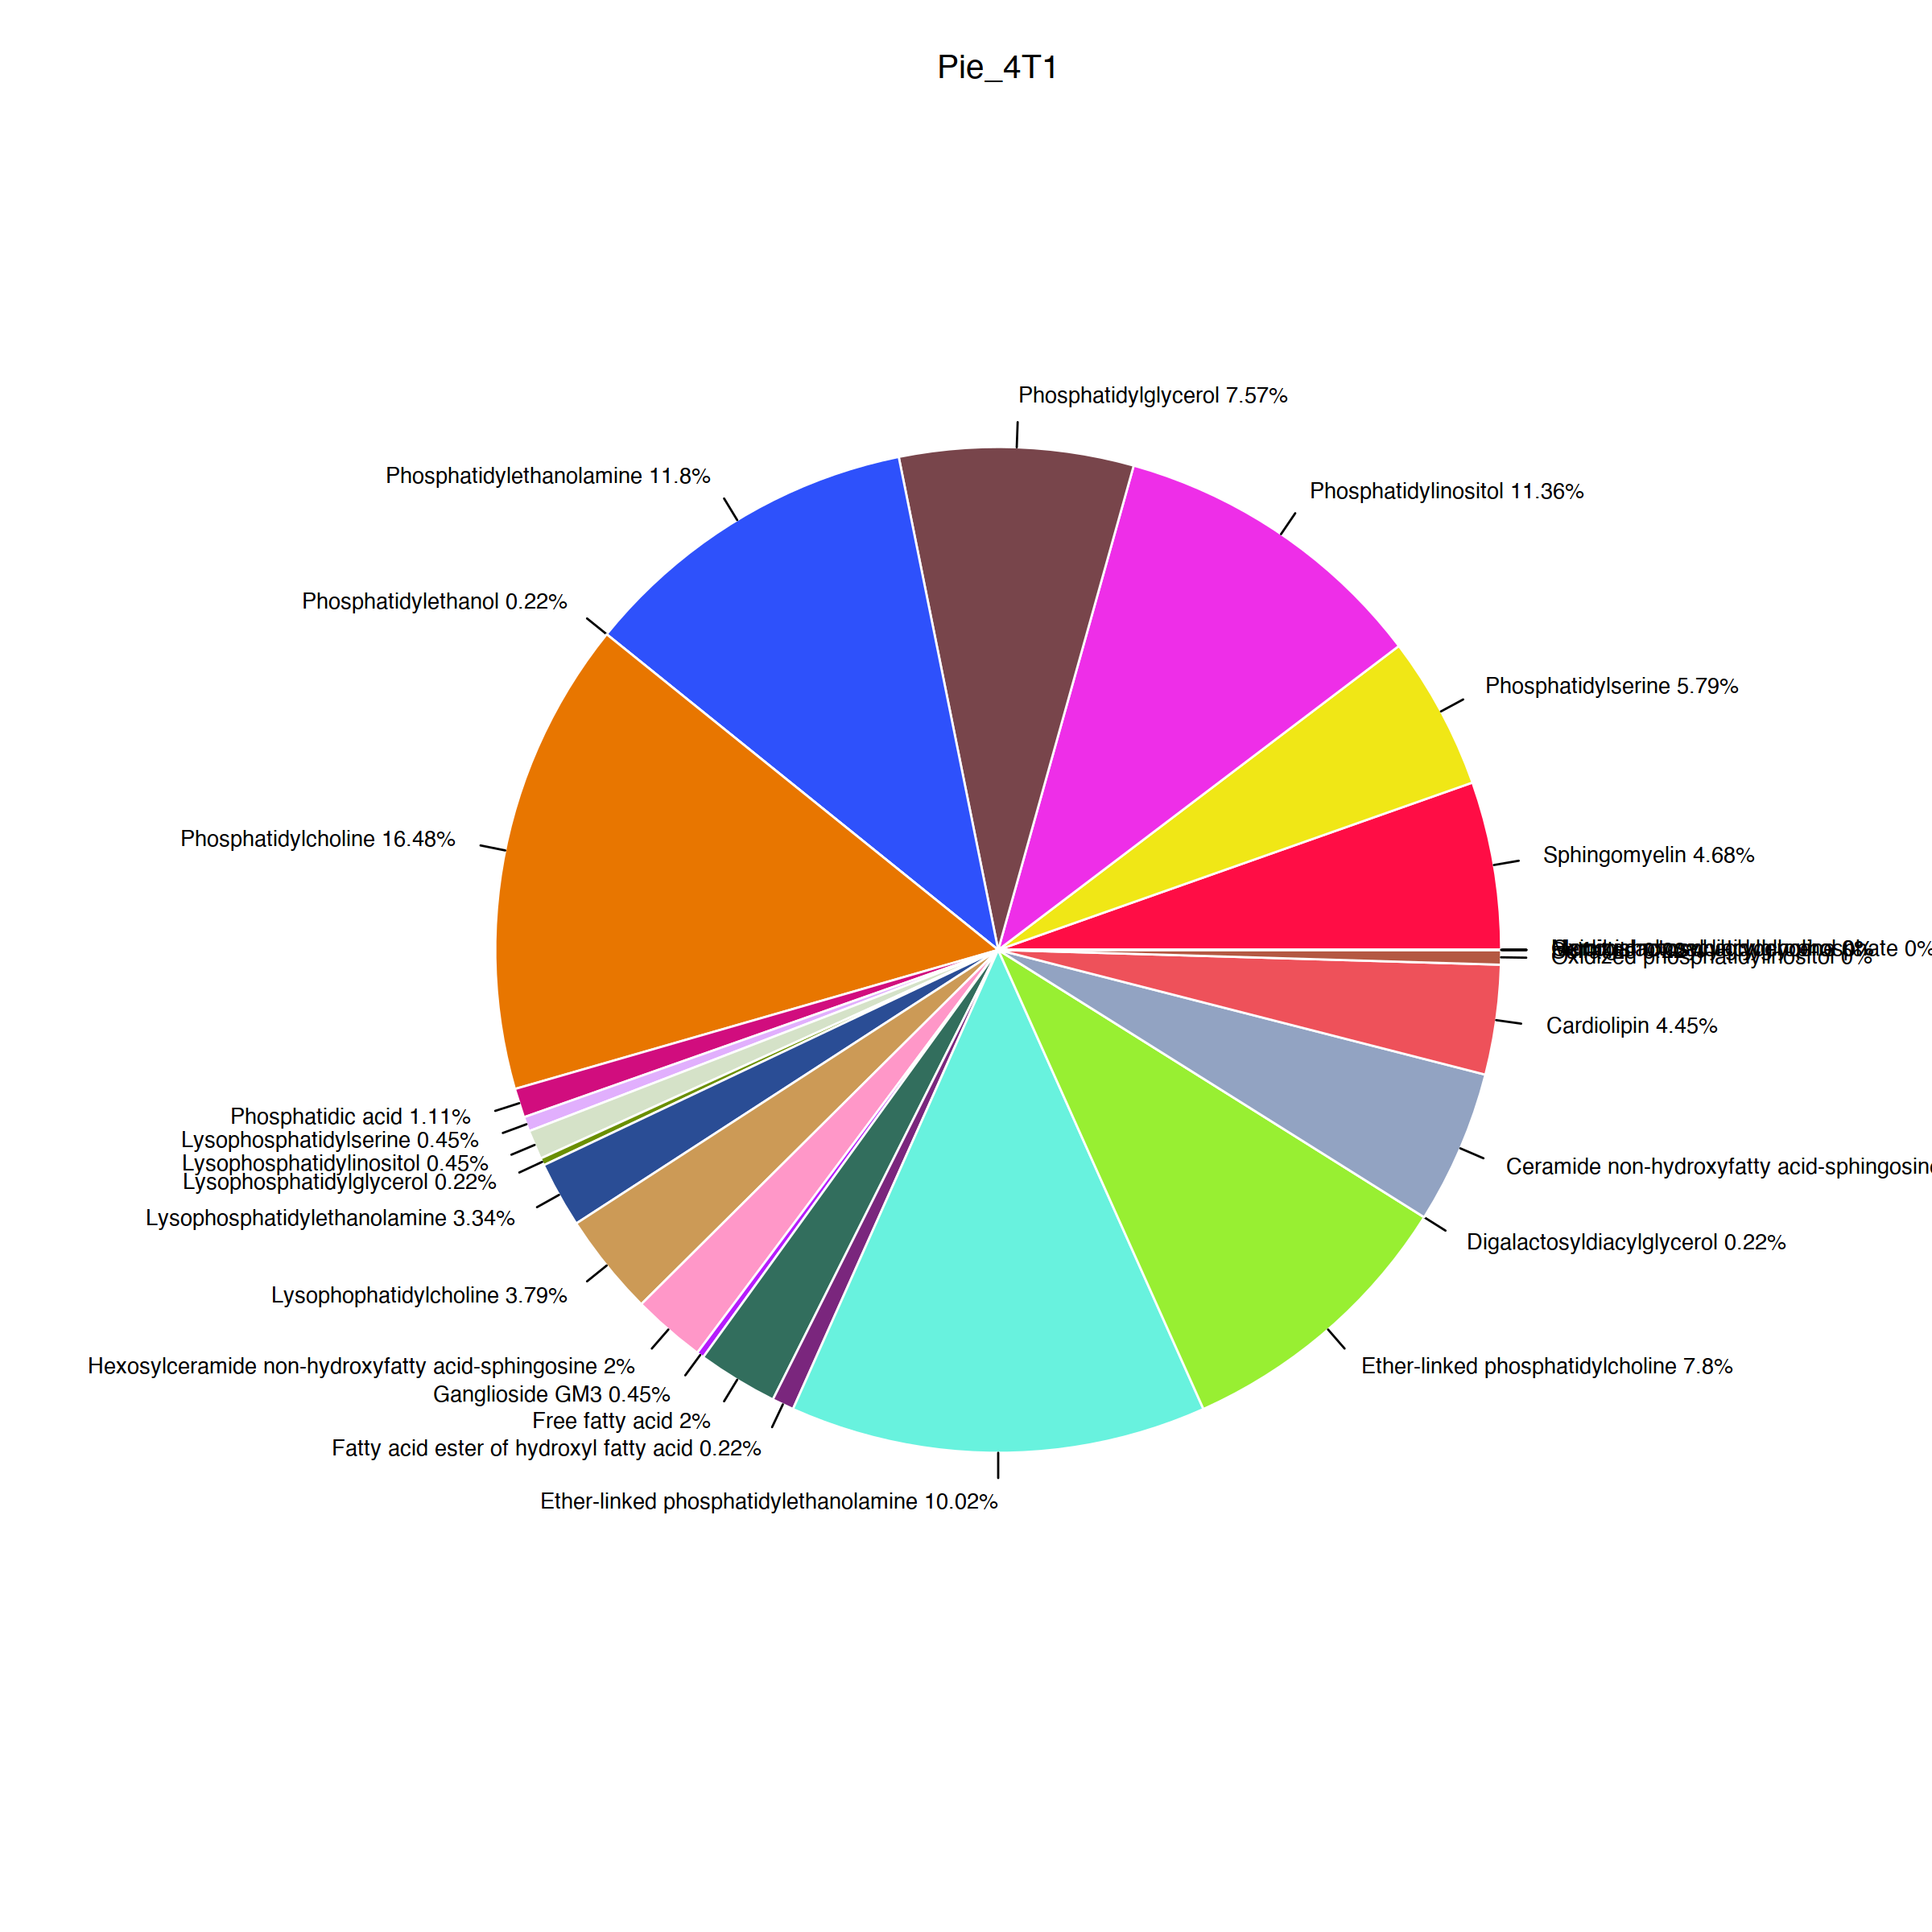

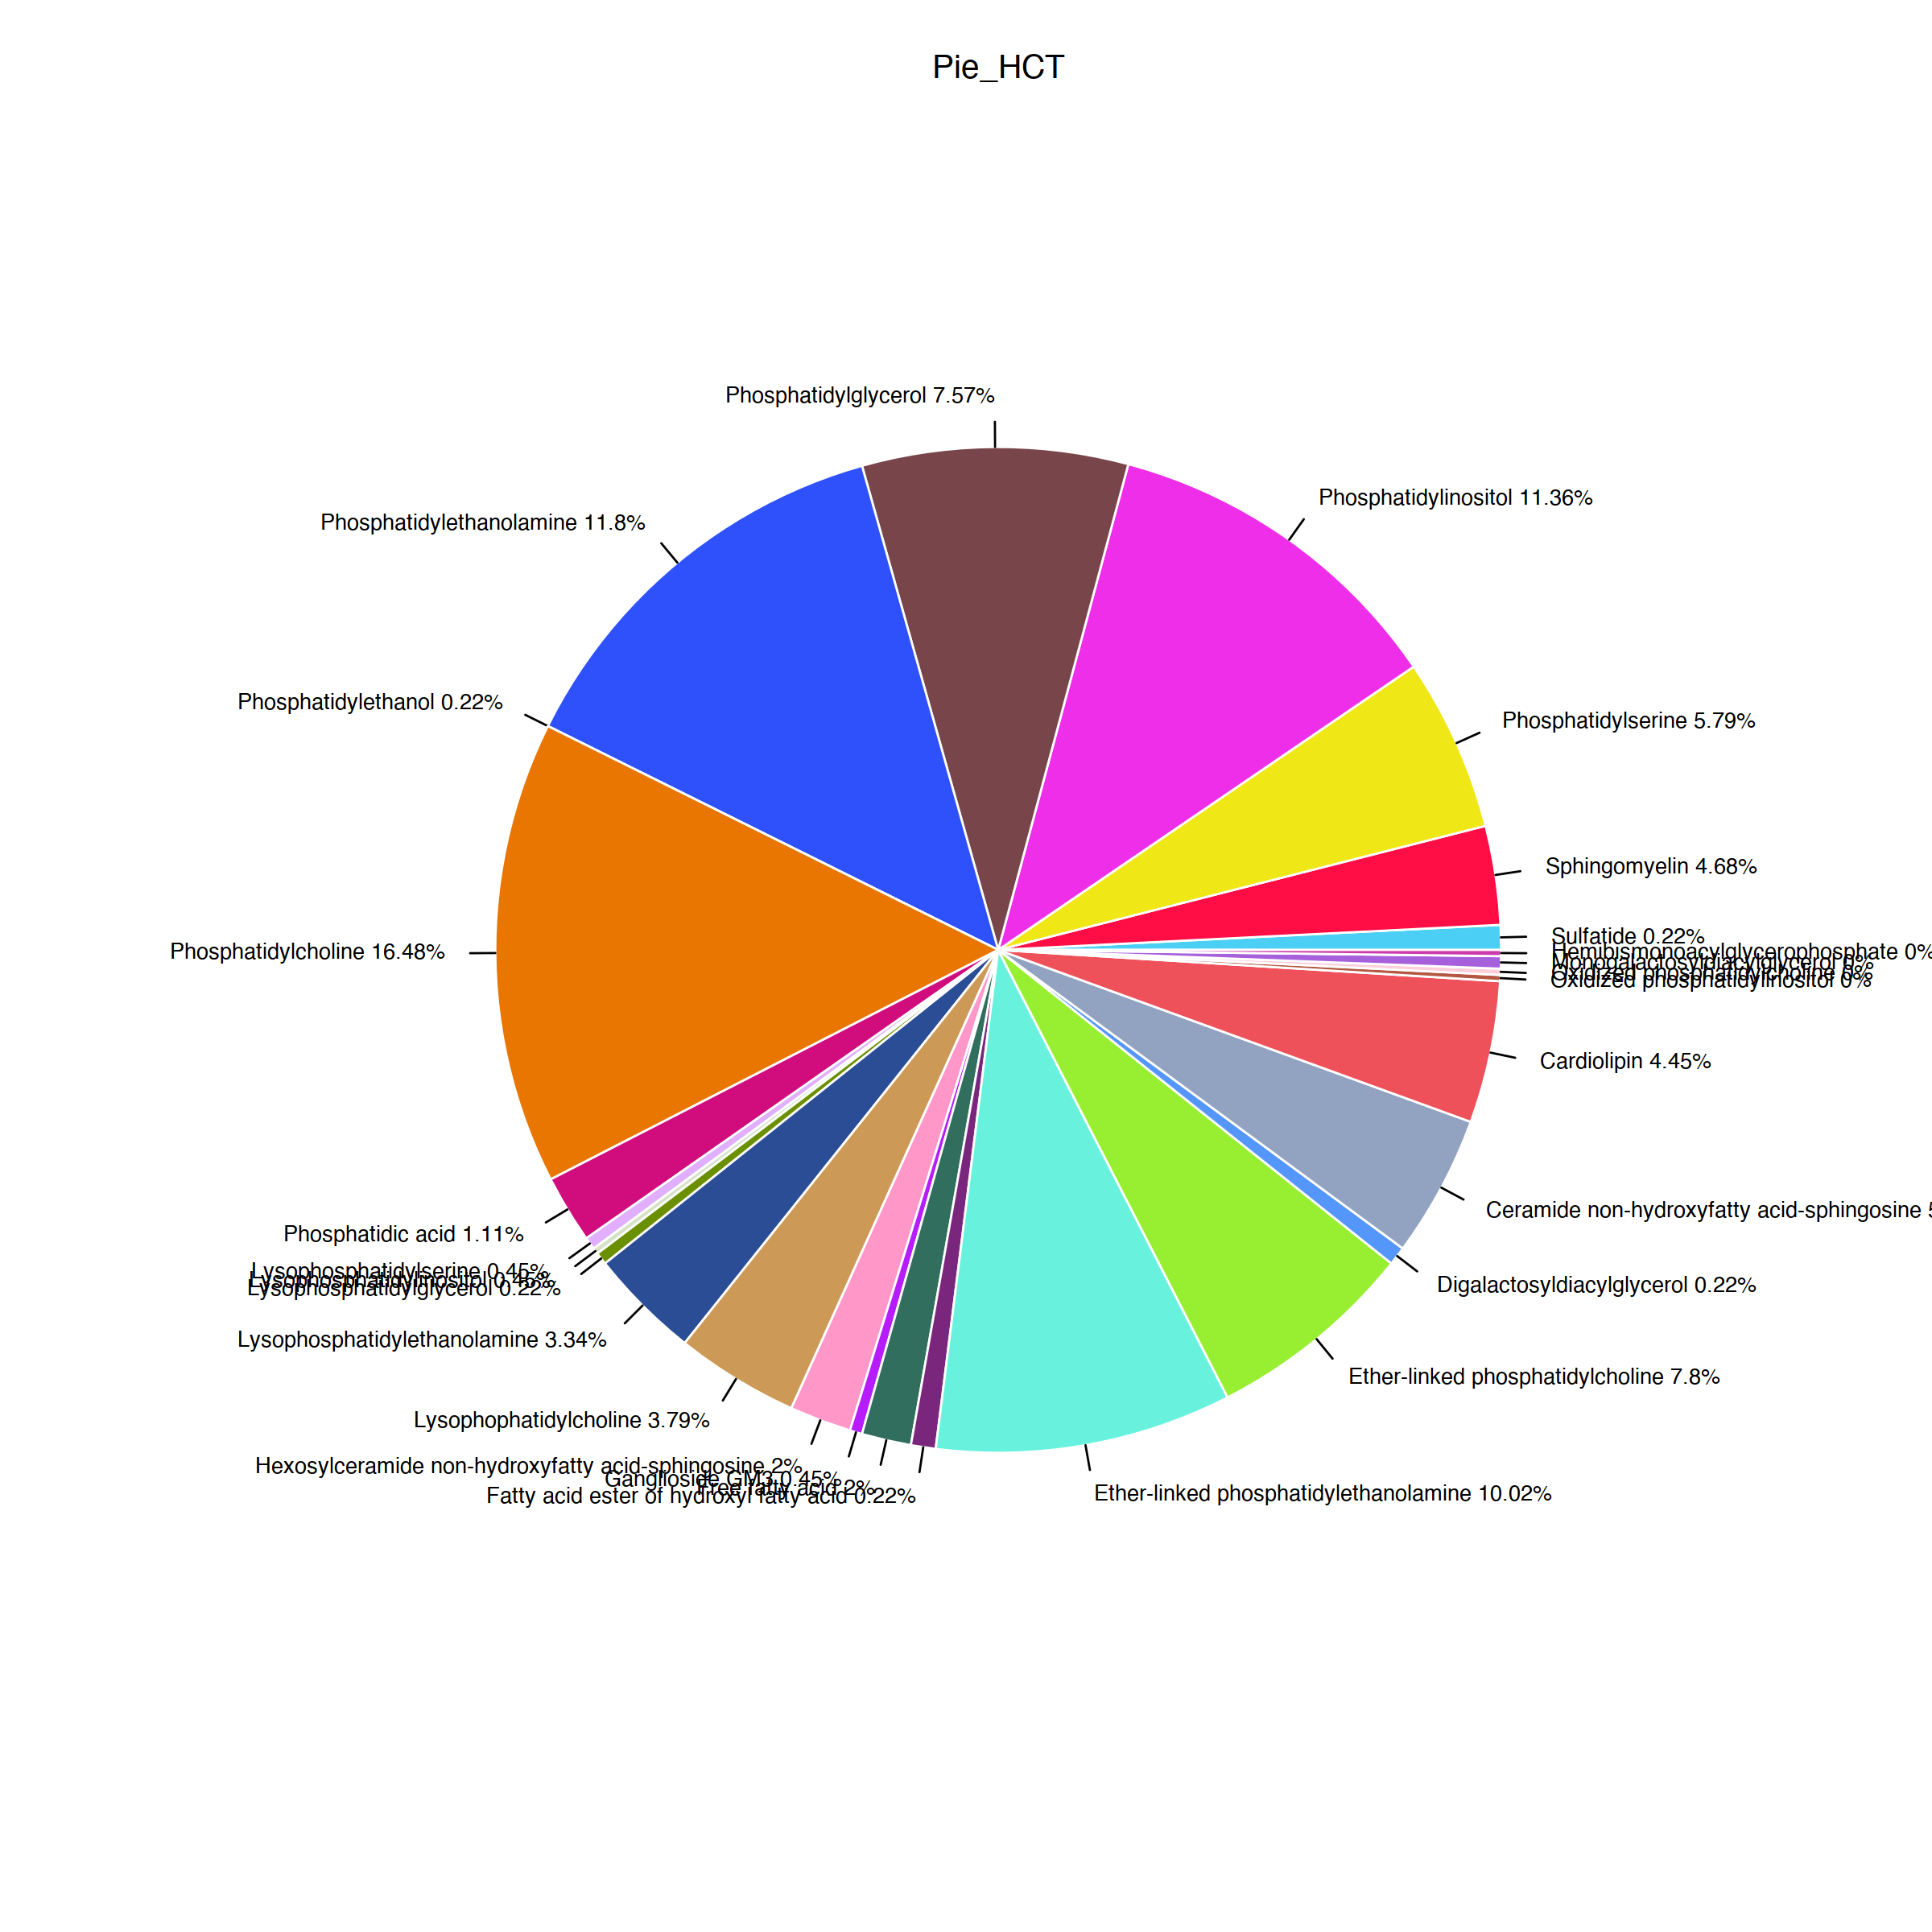

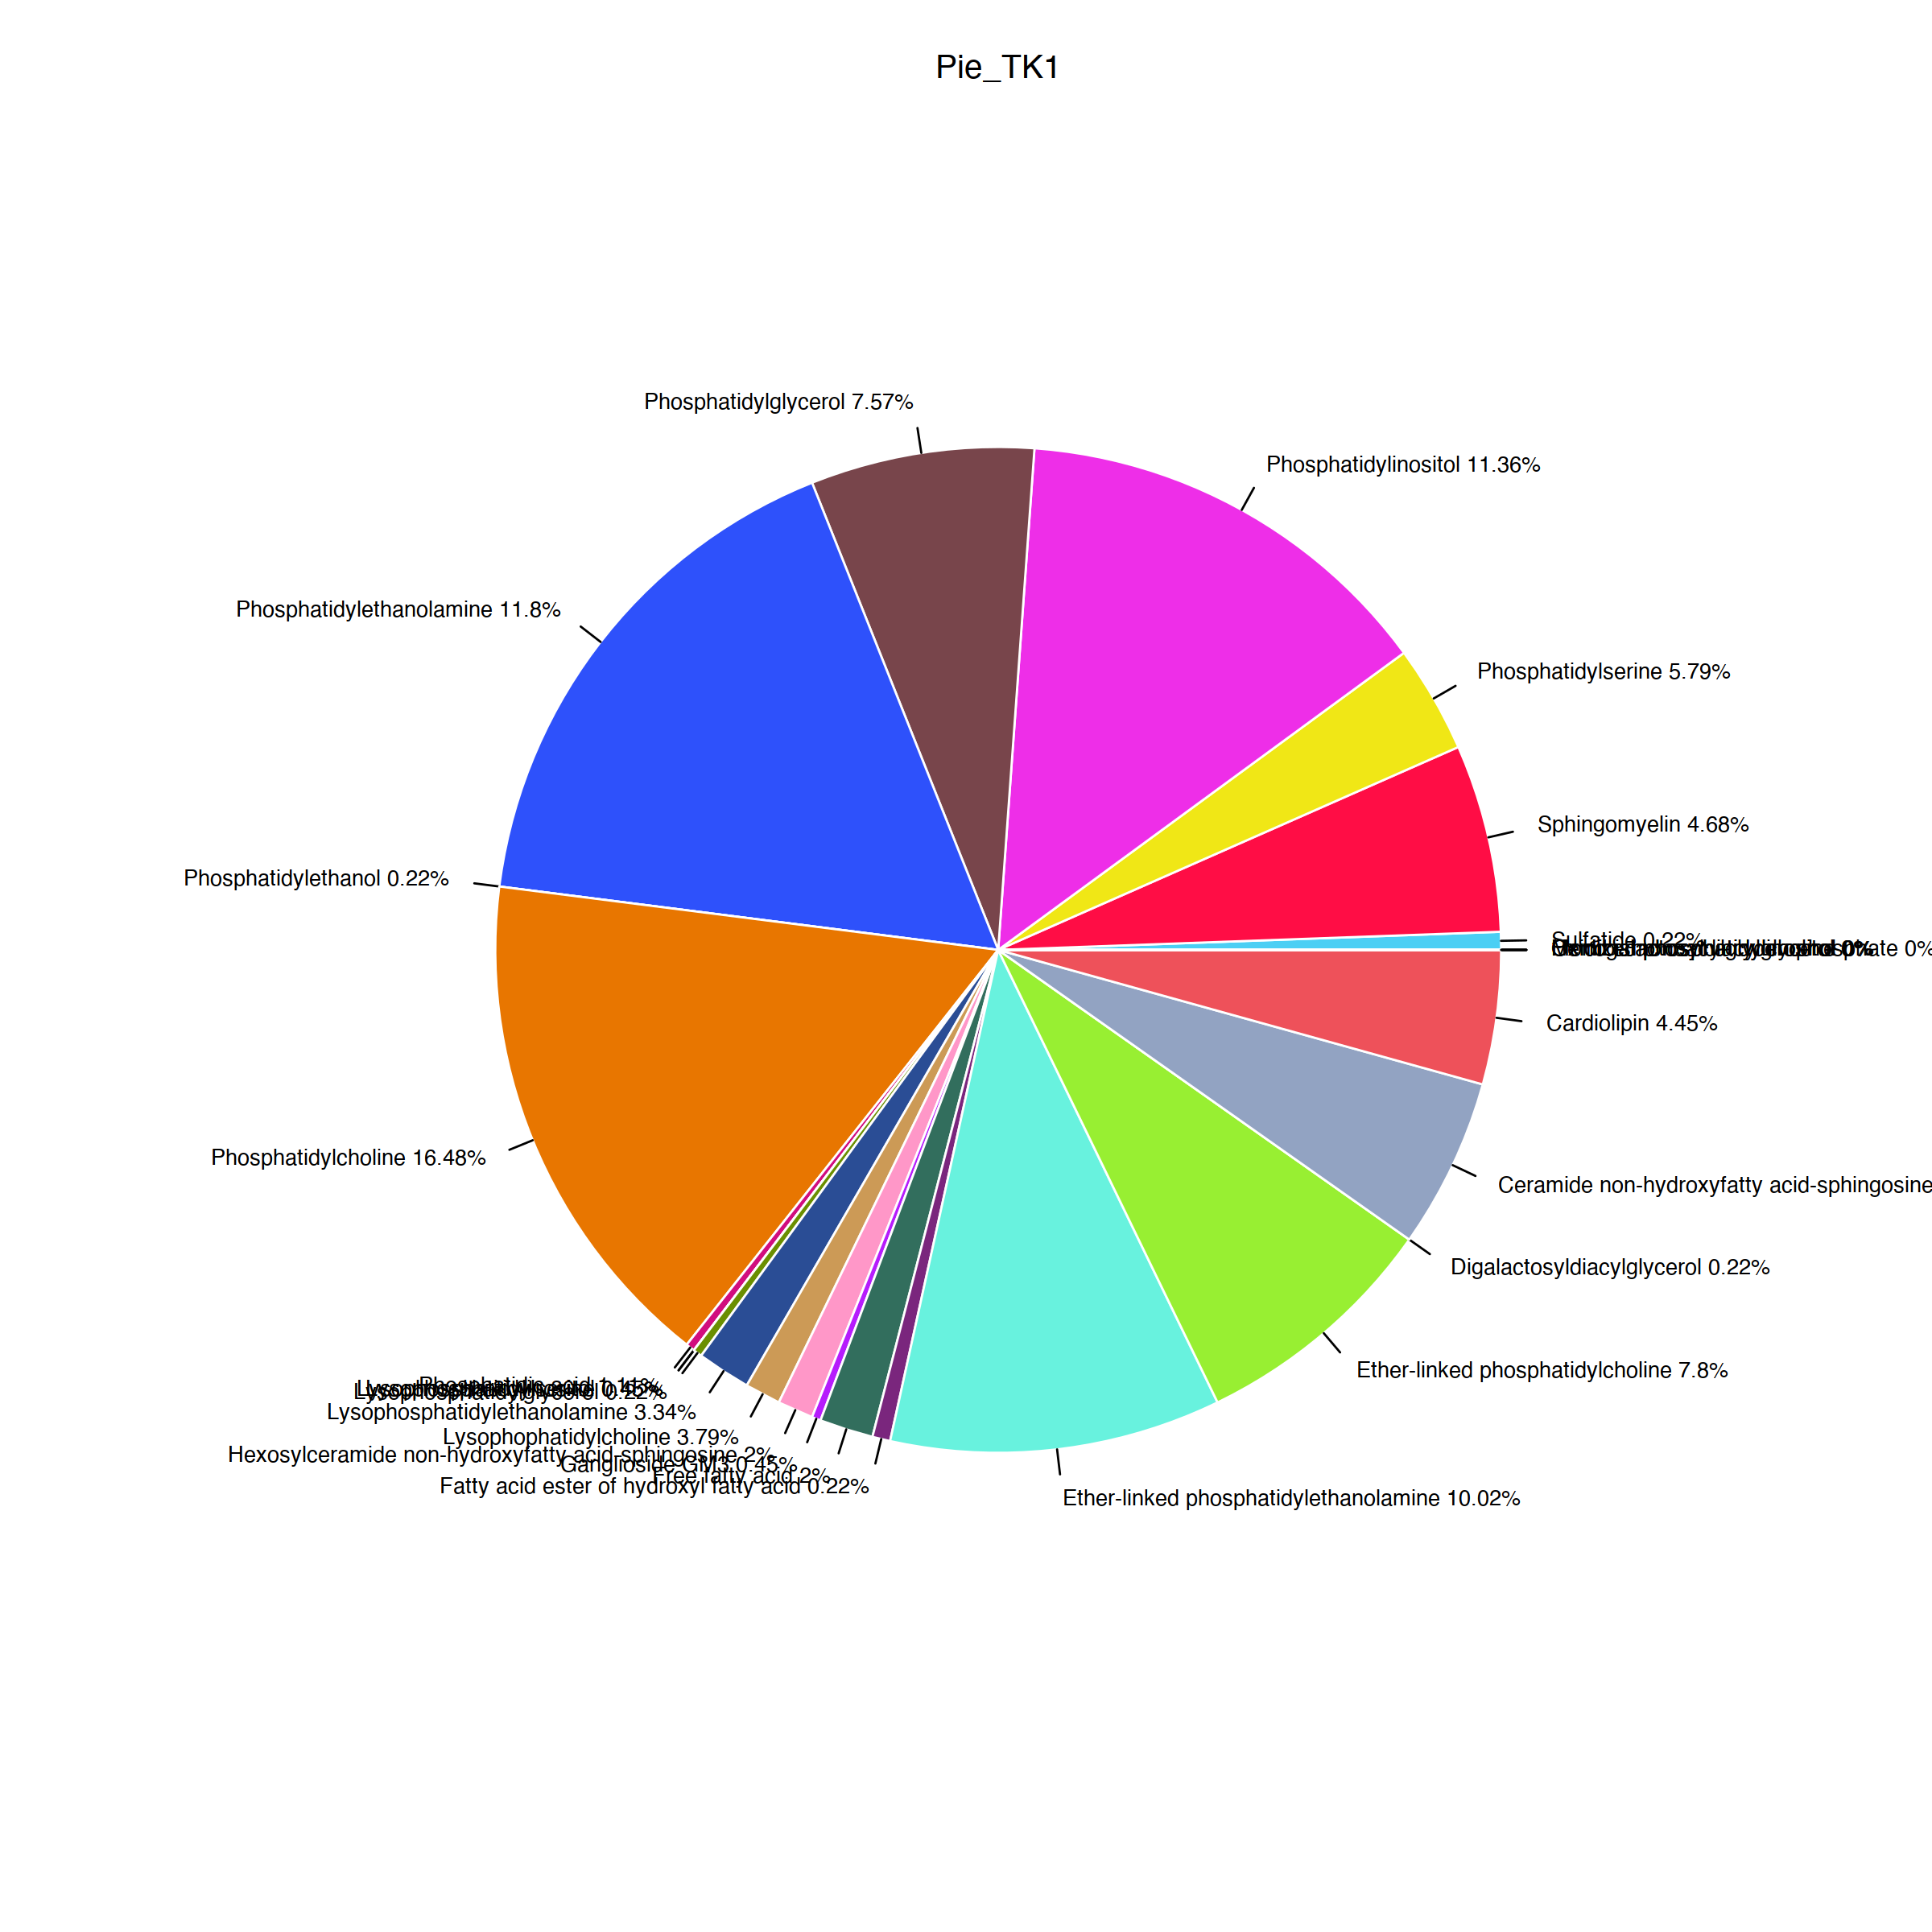

In [20]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 200, repr.plot.quality = 300, repr.plot.pointsize = 12)


Print_Pie(Pie_All)
Print_Pie(Pie_4T1)
Print_Pie(Pie_HCT)
Print_Pie(Pie_TK1)

#### Save piecharts as PDF

In [21]:
pdf(file = "piecharts of lipid annotations from pooled QCs.pdf", width = 18, height = 12, family = "Helvetica") 

Print_Pie(Pie_All)
Print_Pie(Pie_4T1)
Print_Pie(Pie_HCT)
Print_Pie(Pie_TK1)

dev.off()

pdf 
  2

# Create faceted stacked bar charts of absolute annotation counts (rather than relative as in pie charts)

In [22]:
unique (Counts_all$Cell_method)

[1] "PooledQC_all_cells" "PooledQC_4T1_cells" "PooledQC_HCT_cells"
[4] "PooledQC_TK1_cells"

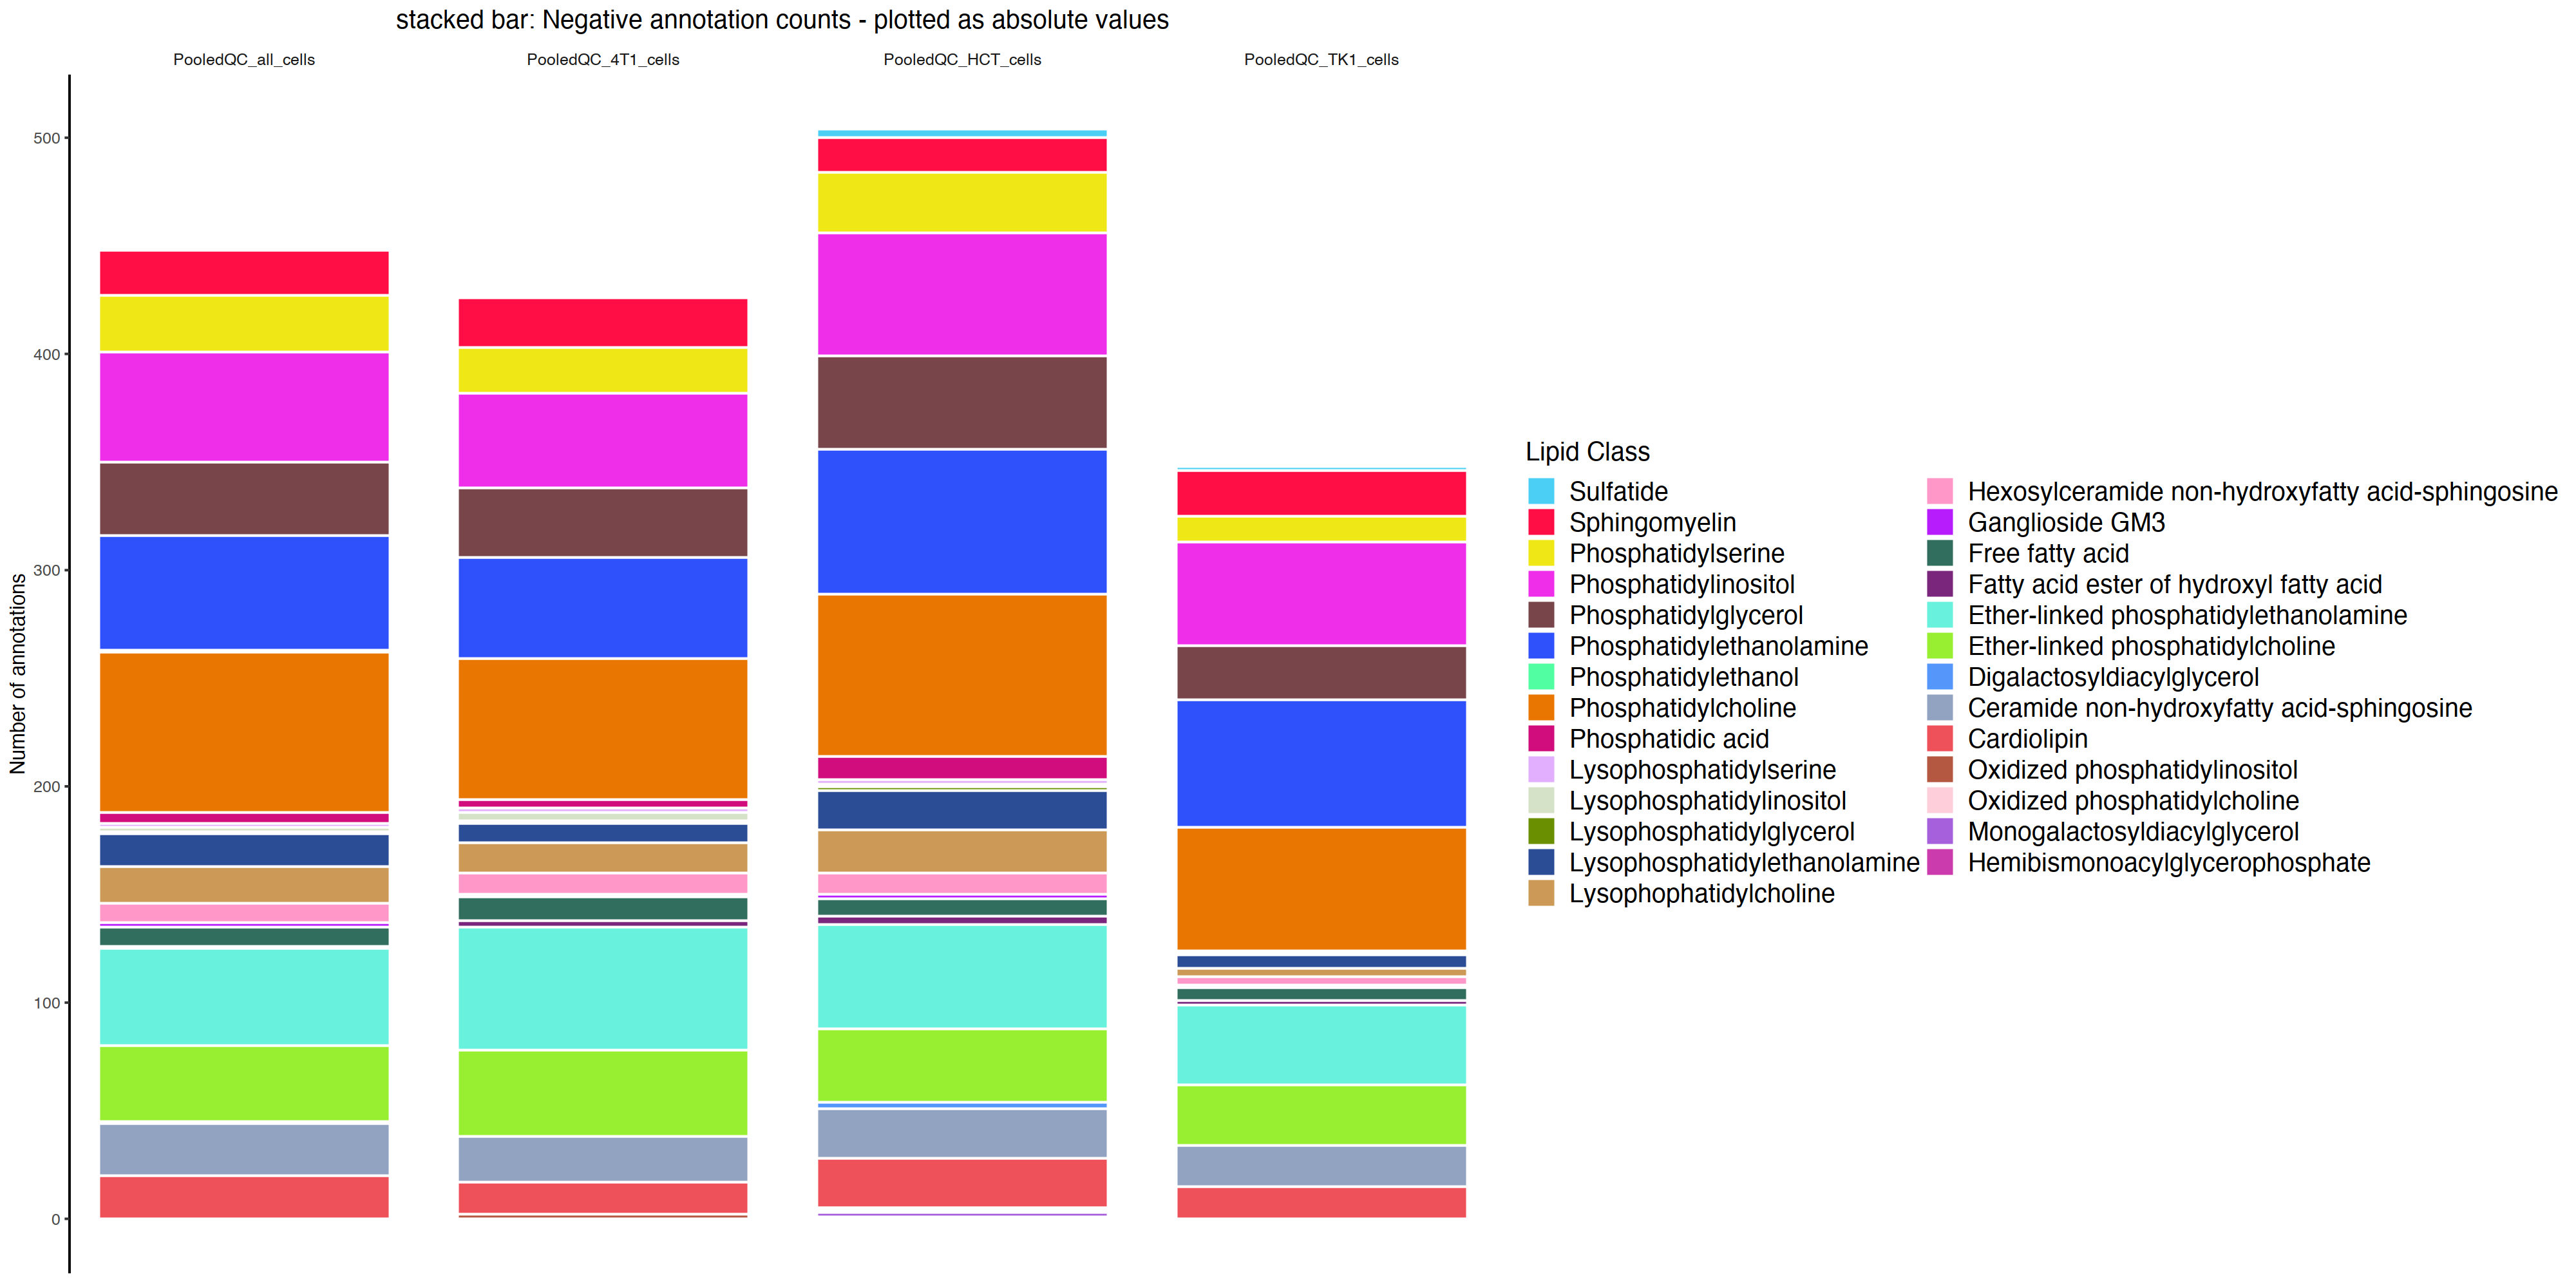

In [23]:
Counts_all$Cell_method <- factor(Counts_all$Cell_method, c('PooledQC_all_cells','PooledQC_4T1_cells','PooledQC_HCT_cells','PooledQC_TK1_cells')) # order of graphs


options(repr.plot.width=20, repr.plot.height=10, repr.plot.res = 200, repr.plot.quality = 300, repr.plot.pointsize = 12)

ggplot(Counts_all, aes (x="", y = Counts, fill = factor(Lipid.Class))) + 
  geom_bar(width = 1, stat = "identity", color = "white") +
  theme_classic() +
 scale_fill_manual(values = ConditionsPalette)+
  theme(plot.title = element_text(hjust=0.5),
        axis.line.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()) +
  labs(fill = "Lipid Class",
       x = NULL,
       y = "Number of annotations",
       title = "stacked bar: Negative annotation counts - plotted as absolute values") + 
facet_wrap(~Cell_method, ncol =4,labeller = label_wrap_gen()) +
  theme(strip.background = element_blank())+
theme(plot.title = element_text(size = 14, face = "bold"),
    legend.title=element_text(size=14), 
    legend.text=element_text(size=14))


##### Save stacked barchart as PDF

In [24]:
pdf(file = "faceted stacked bar chart absolute annotations_neg.pdf", width = 20, height = 12, family = "Helvetica") 

ggplot(Counts_all, aes (x="", y = Counts, fill = factor(Lipid.Class))) + 
  geom_bar(width = 1, stat = "identity", color = "white") +
  theme_classic() +
 scale_fill_manual(values = ConditionsPalette)+
  theme(plot.title = element_text(hjust=0.5),
        axis.line.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()) +
  labs(fill = "Lipid Class",
       x = NULL,
       y = "Number of annotations",
       title = "stacked bar: Negative annotation counts - plotted as absolute values") + 
facet_wrap(~Cell_method, ncol =4,labeller = label_wrap_gen()) +
  theme(strip.background = element_blank())+
theme(plot.title = element_text(size = 14, face = "bold"),
    legend.title=element_text(size=14), 
    legend.text=element_text(size=14))

dev.off()

pdf 
  2